In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *


import scipy
import scipy.sparse as sp
import time
#from tqdm.notebook import trange, tqdm
from qutip.solver import Options, Result

from scipy.integrate import quad
from scipy.optimize import curve_fit

from scipy.sparse.linalg import lgmres,gcrotmk,gmres, qmr

In [2]:
def _Is(i): return [qeye(2) for j in range(0, i)]
def _sm(N, i): return tensor(_Is(i) + [destroy(2)] + _Is(N - i - 1))
def _sz(N, i): return tensor(_Is(i) + [qeye(2)-2*destroy(2).dag() * destroy(2)] + _Is(N - i - 1))
def _oprd(lst): return np.prod(np.array(lst, dtype=object))
def _f(N, n): return _oprd([_sz(N, j) for j in range(n)])*_sm(N,n)
def Hamiltonian_single(H):
    return - 1j * (spre(H) - spost(H))

In [3]:
Ncc = 5
lmaxl=2
#lmaxl=4

#########################
### system: two fermions
N = 2
d_1 = _f(N,0)
d_2 = _f(N,1)

#bath params:
mu = 0.  #chemical potential
Gamma  = 1  #coupling strenght
W = 2.5 #bath width

#system params:
#coulomb repulsion
U = 3 * np.pi * Gamma
#impurity energy
w0 = - U / 2.

beta = 1 / (0.2 * Gamma)

Qops = [d_1.dag(),d_1,d_2.dag(),d_2]

L = w0 * Hamiltonian_single(d_1.dag() * d_1) + w0 * Hamiltonian_single(d_2.dag() * d_2) 
L = L + U * Hamiltonian_single(d_1.dag() * d_1 * d_2.dag() * d_2)

times = np.linspace(0,10,20000)
PadeBath=heom.LorentzianPadeBath(sum(Qops),2*Gamma,W,mu,1/beta,lmaxl)

In [4]:
coeffsplus=PadeBath._corr(2*Gamma,W,mu,1/beta,lmaxl,sigma=1)
coeffsminus=PadeBath._corr(2*Gamma,W,mu,1/beta,lmaxl,sigma=-1)

In [5]:
bath1 = heom.FermionicBath(d_1, coeffsplus[0], coeffsplus[1], coeffsminus[0], coeffsminus[1], tag ="1")
bath2 = heom.FermionicBath(d_2, coeffsplus[0], coeffsplus[1], coeffsminus[0], coeffsminus[1], tag ="2")

In [6]:
gs = basis(2,0)*basis(2,0).dag()
psi0 = tensor(gs,gs)

In [7]:
resultHEOMPade = heom.HEOMSolver(L, [bath1,bath2], Ncc)  #<---- normal parity HEOM to get normal steadystate

In [8]:
rhossHP3_pade, fullss= resultHEOMPade.steady_state()
expect(rhossHP3_pade, d_1.dag()*d_1)

0.49999999999167505

In [9]:
M_1 = resultHEOMPade.rhs
sup_dim = resultHEOMPade._sup_shape
N_he  = resultHEOMPade._n_ados

In [10]:


rhoptemp = fullss._ado_state.reshape((N_he*sup_dim, 1))
unit_helems = sp.identity(N_he, format='csr')
resultHEOMPade2 = heom.HEOMSolver(L, [bath1,bath2], Ncc, odd_parity=True) #<------ use ODD parity for this RHS

M_2 = resultHEOMPade2.rhs  ##PARITY MODIFIED RHS<------


sup_dim = resultHEOMPade2._sup_shape
N_he  = resultHEOMPade2._n_ados

###################################

d_1_big = sp.kron(unit_helems, sp.csr_matrix(spre(d_1).full()))
rho0d1 = np.array(d_1_big @ rhoptemp, dtype=complex)

# ######################################

d_1_bigdag = sp.kron(unit_helems, sp.csr_matrix(spre(d_1.dag()).full()))
rho0d1dag = np.array(d_1_bigdag @  rhoptemp, dtype=complex)




In [11]:
M2=sp.csr_matrix(M_2.to_list()[0].full())
M2

<25376x25376 sparse matrix of type '<class 'numpy.complex128'>'
	with 241176 stored elements in Compressed Sparse Row format>

In [12]:
wlist = np.linspace(-15,15,100)


Nfull = N_he*sup_dim
c_I = sp.identity(Nfull)
def D2(w):
    return (M2-1.0j*w*c_I)

def D3(w):
     return (1.0j*w*c_I+M2)

I = tensor([qeye(n) for n in d_1.dims[0]])
I_vec3 = sp.csr_matrix(operator_to_vector(I).full().T)

def inverse(w_list):
    ddagd = []
    dddag = []
    fid3 = []
    fid2 =[]
    #for idx in trange(len(w_list),desc='w range'):
    for idx in range(len(w_list)):
        w=w_list[idx]
    #for w in w_list:
        w = w_list[idx]
        x2, fidelity2 = lgmres(D2(w), rho0d1)
        Cw21 = d_1_bigdag  @ x2
        Cw22 =  (I_vec3 @ Cw21[:sup_dim])
        ddagd.append(Cw22)
        fid2.append(fidelity2)
        
        x3, fidelity3 = lgmres(D3(w),  rho0d1dag)
        Cw31 = d_1_big @ x3
        Cw32 =  (I_vec3 @ Cw31[:sup_dim])
        dddag.append(Cw32)
        fid3.append(fidelity3)
       
    return ddagd, dddag, fid2, fid3

ddagdpadelmax2nc5,  dddagpadelmax2nc5, fid2, fid3 = inverse(wlist)

/tmp/ipykernel_5255/468189688.py:25: DeprecationWarning: scipy.sparse.linalg.lgmres called without specifying `atol`. The default value will change in the future. To preserve current behavior, set ``atol=tol``.
  x2, fidelity2 = lgmres(D2(w), rho0d1)
/tmp/ipykernel_5255/468189688.py:31: DeprecationWarning: scipy.sparse.linalg.lgmres called without specifying `atol`. The default value will change in the future. To preserve current behavior, set ``atol=tol``.
  x3, fidelity3 = lgmres(D3(w),  rho0d1dag)


In [13]:
plt.rcParams['figure.figsize'] = (7, 5)
plt.rcParams['axes.titlesize'] = 25
plt.rcParams['axes.labelsize'] = 30
plt.rcParams['xtick.labelsize'] = 28
plt.rcParams['ytick.labelsize'] = 28
plt.rcParams['legend.fontsize'] = 28
plt.rcParams['axes.grid'] = False
plt.rcParams['savefig.bbox'] = 'tight'
plt.rcParams['lines.markersize'] = 5
plt.rcParams['font.family'] = 'STIXgeneral' 
plt.rcParams['mathtext.fontset'] =  'stix'
plt.rcParams["font.serif"] = "STIX"
plt.rcParams['text.usetex'] = False

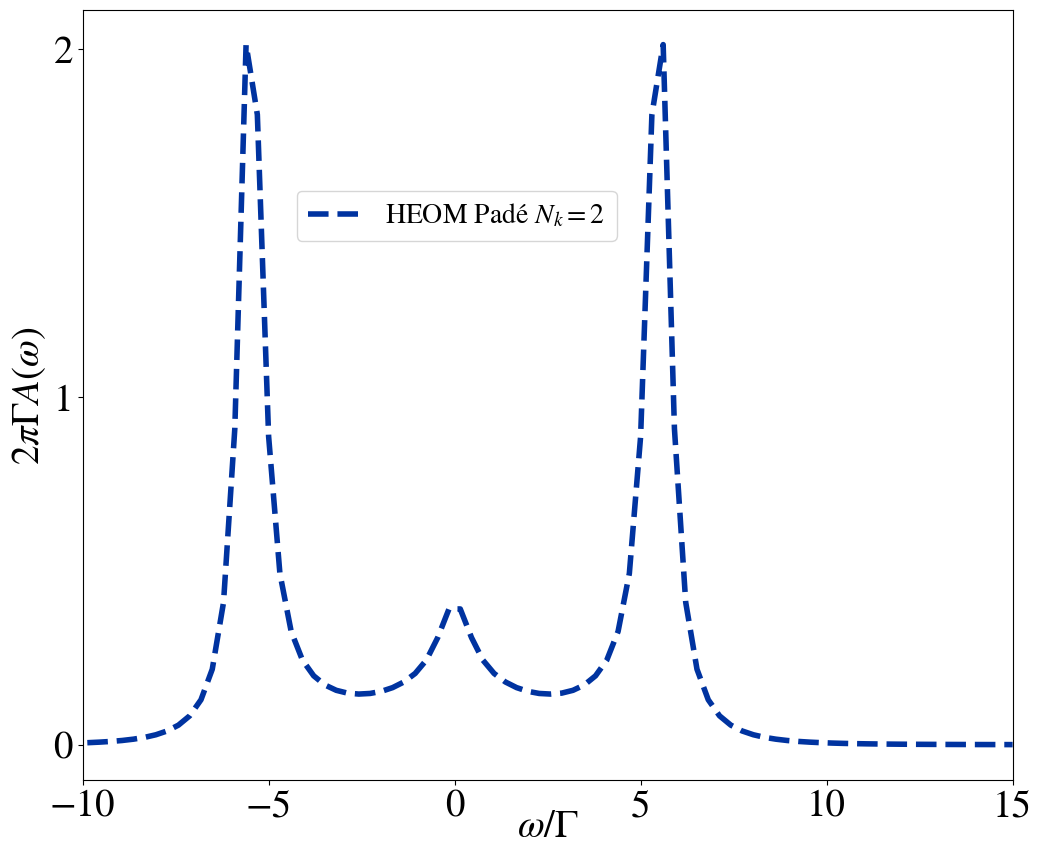

In [14]:

plt.rcParams["figure.figsize"] = (12,10)


plt.plot(wlist,-2*np.real((np.array(ddagdpadelmax2nc5)+np.array(dddagpadelmax2nc5))),color='#0033A0',linestyle='--',label=r"HEOM Padé $N_k = 2$",linewidth=4,alpha = 1)

plt.legend(fontsize=20,loc = (0.23,0.7))

plt.xlim(-10,15)

plt.yticks([0.,1,2],[0,1,2])


plt.xlabel(r"$\omega/\Gamma$",fontsize=28,labelpad=-10)
plt.ylabel(r"$2\pi \Gamma A(\omega)$ ",fontsize=28)

         
plt.show()